In [1]:
import warnings

import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm

from pymc_marketing.mmm import GeometricAdstock, MichaelisMentenSaturation
from pymc_marketing.mmm.MultiDimensionalMMM import MMM

In [2]:
warnings.filterwarnings("ignore", category=FutureWarning)

az.style.use("arviz-darkgrid")
plt.rcParams["figure.figsize"] = [12, 7]
plt.rcParams["figure.dpi"] = 100

%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = "retina"

In [3]:
MMM

pymc_marketing.mmm.MultiDimensionalMMM.MMM

In [4]:
GeometricAdstock

pymc_marketing.mmm.components.adstock.GeometricAdstock

In [5]:
# Generate a date range
date_range = pd.date_range(start="2023-01-01", end="2023-01-10")

# Define countries and channels
countries = ["Venezuela", "Colombia", "Chile", "Argentina"]
channels = ["a", "b"]

# Create a DataFrame
data = []
for country in countries:
    for date in date_range:
        record = [date, country, *list(np.random.randint(100, 500, size=len(channels)))]
        data.append(record)

df = pd.DataFrame(data, columns=["date", "country", *channels])
df["target"] = df[channels].sum(axis=1) + np.random.randint(100, 500, size=len(df))
df.head()

,date,country,a,b,target
0,2023-01-01,Venezuela,201,224,660
1,2023-01-02,Venezuela,329,310,992
2,2023-01-03,Venezuela,164,182,829
3,2023-01-04,Venezuela,395,451,1335
4,2023-01-05,Venezuela,432,322,893


In [6]:
from pymc_marketing.prior import Prior

# Strange error here.
hierarchical_alpha = Prior(
    "Gamma",
    mu=Prior("HalfNormal", sigma=1, dims="country"),
    sigma=Prior("HalfNormal", sigma=1, dims="country"),
    dims=("channel", "country"),
)
common_lam = Prior("HalfNormal", sigma=1, dims=("channel",))
priors = {
    "alpha": hierarchical_alpha,
    "lam": common_lam,
}

# Not working with hierarchical priors

In [7]:
mmm = MMM(
    date_column="date",
    target_column="target",
    channel_columns=["a", "b"],
    dims=("country",),
    adstock=GeometricAdstock(l_max=2),
    saturation=MichaelisMentenSaturation(),
    yearly_seasonality=12,
    time_varying_media=True,
    time_varying_intercept=True,
)

In [8]:
mmm.fit(
    X=df.drop(columns="target"),
    y=df.drop(columns=channels),
    chains=4,
    target_accept=0.85,
    nuts_sampler="numpyro",
)

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

There were 53 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


Inference data with groups:
	> posterior
	> sample_stats
	> observed_data
	> constant_data

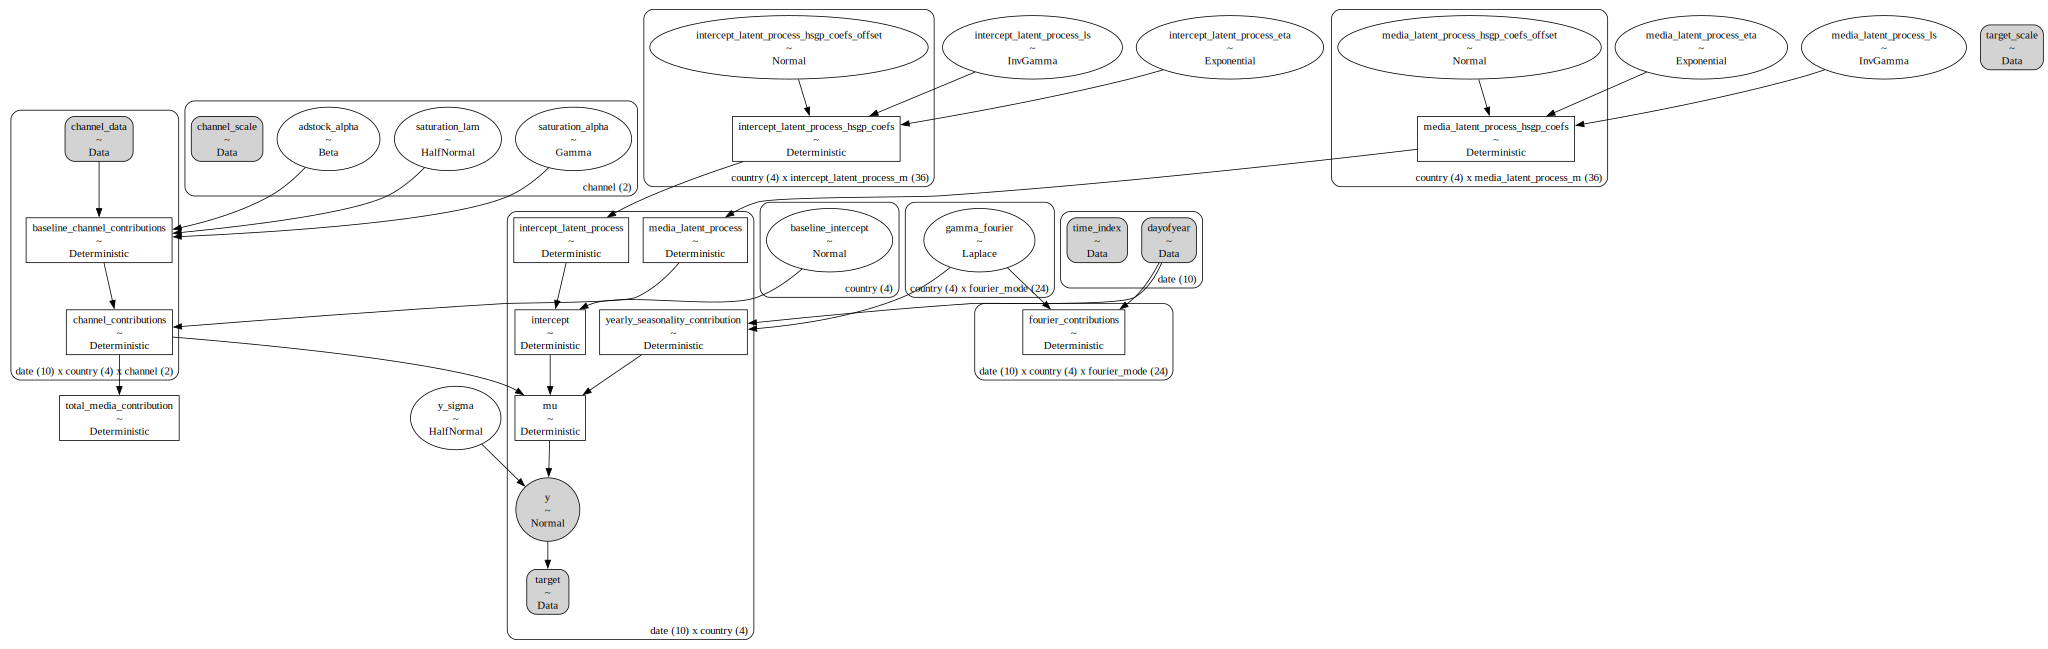

In [9]:
pm.model_to_graphviz(mmm.model)

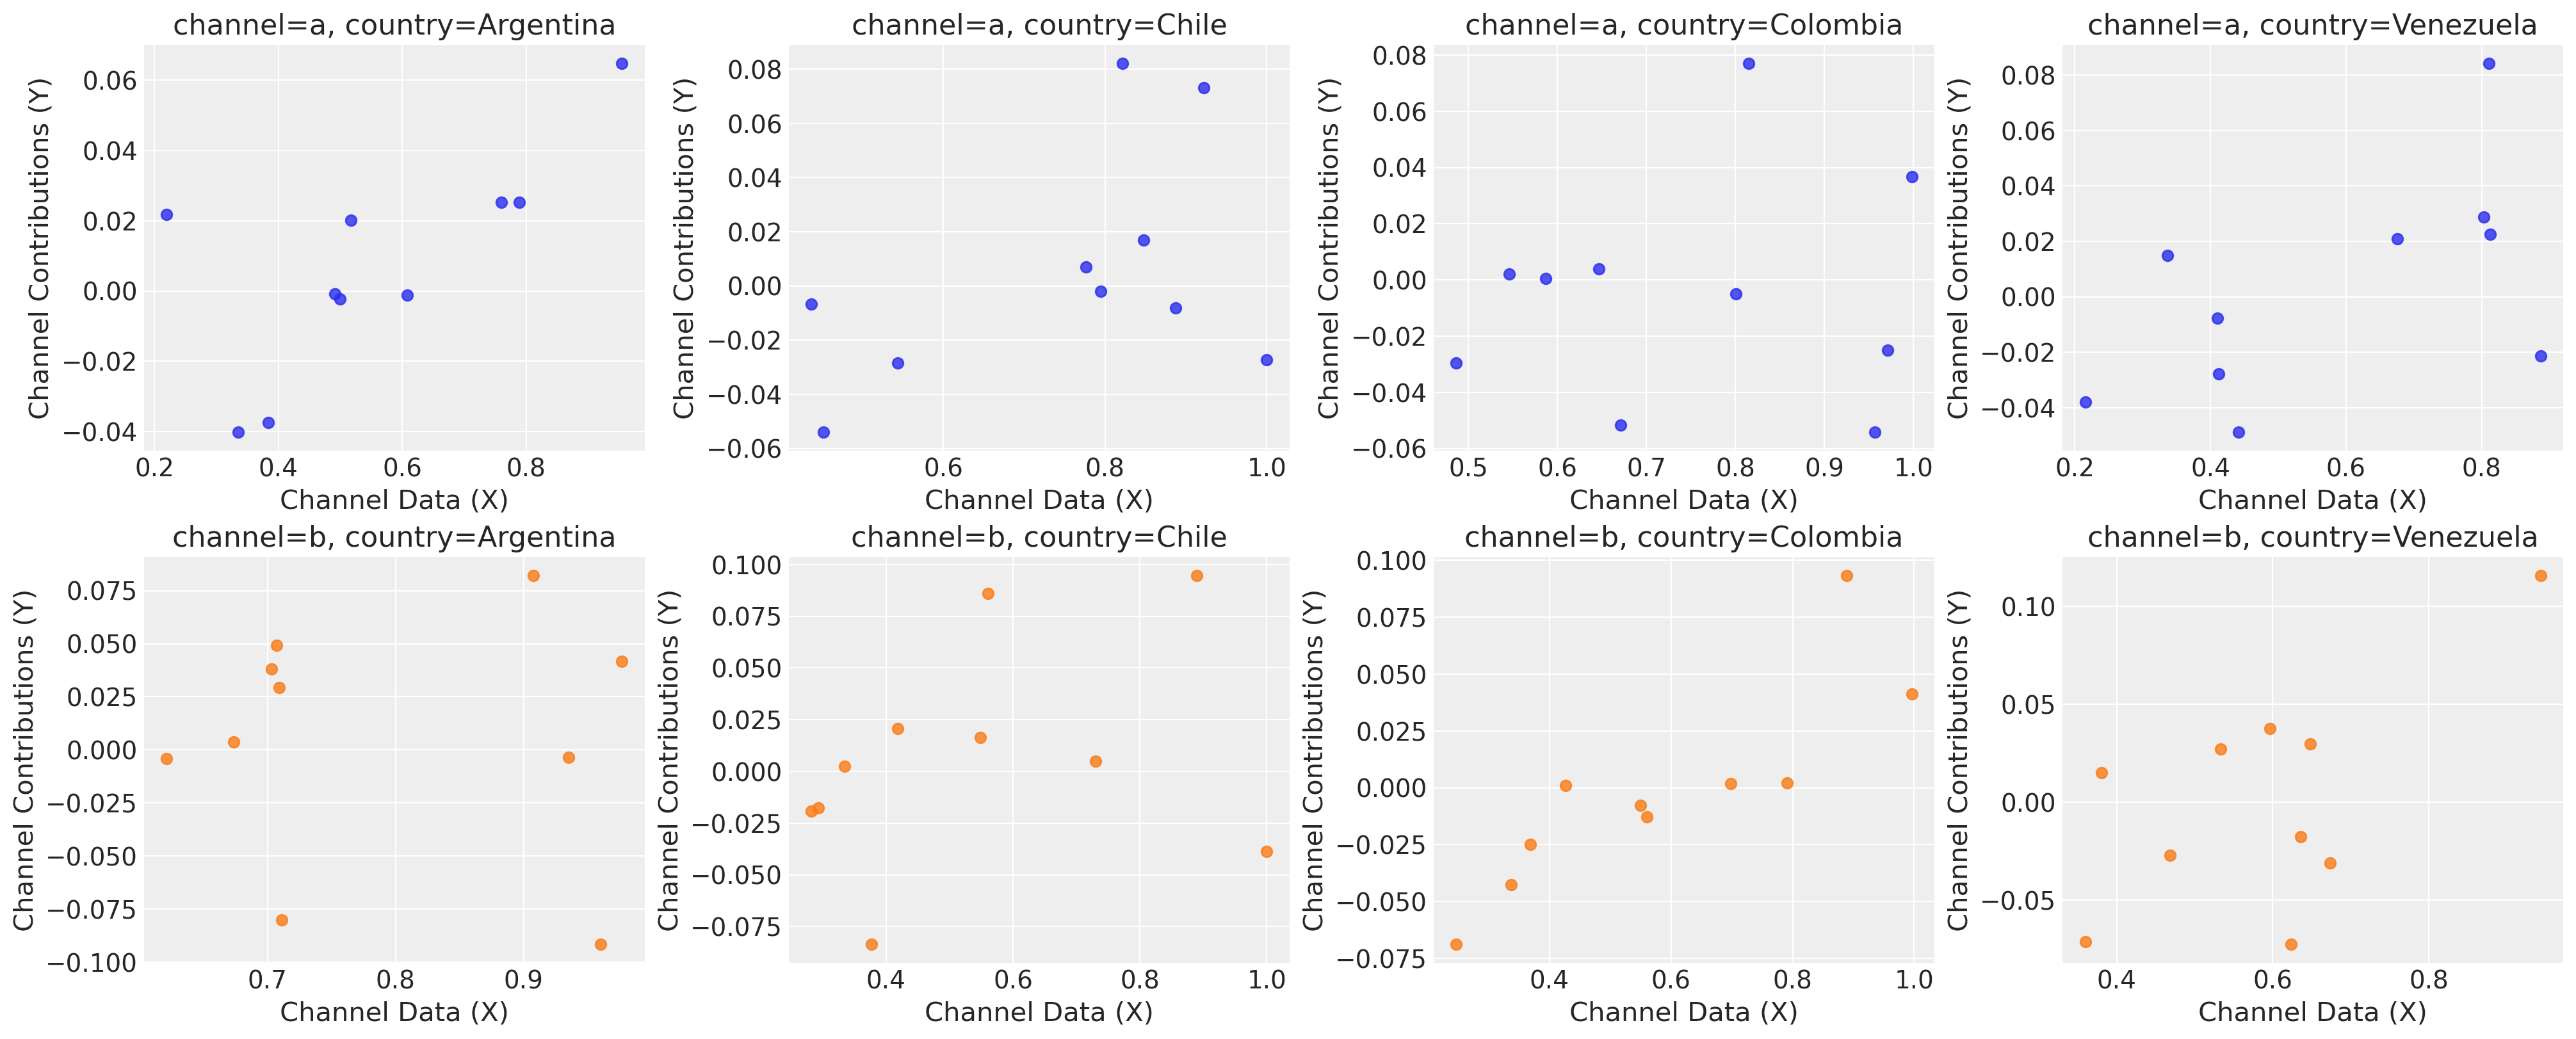

In [10]:
mmm.plot_saturation_curves_scatter();

In [11]:
mmm.sample_posterior_predictive(X=df.drop(columns="target"), y=None)

Sampling: [y]


Output()

<xarray.Dataset> Size: 1MB
Dimensions:  (date: 10, country: 4, sample: 4000)
Coordinates:
  * date     (date) datetime64[ns] 80B 2023-01-01 2023-01-02 ... 2023-01-10
  * country  (country) <U9 144B 'Argentina' 'Chile' 'Colombia' 'Venezuela'
  * sample   (sample) object 32kB MultiIndex
  * chain    (sample) int64 32kB 0 0 0 0 0 0 0 0 0 0 0 ... 3 3 3 3 3 3 3 3 3 3 3
  * draw     (sample) int64 32kB 0 1 2 3 4 5 6 7 ... 993 994 995 996 997 998 999
Data variables:
    y        (date, country, sample) float64 1MB 1.472e+03 1.459e+03 ... 979.2
Attributes:
    created_at:                 2025-01-20T22:40:00.556852+00:00
    arviz_version:              0.20.0
    inference_library:          pymc
    inference_library_version:  5.20.0

In [12]:
mmm.idata

Inference data with groups:
	> posterior
	> posterior_predictive
	> sample_stats
	> observed_data
	> constant_data

In [13]:
mmm.idata.posterior[["saturation_lam","saturation_beta"]]

KeyError: 'saturation_beta'

In [ ]:
mmm.saturation

In [28]:
mmm.saturation.function(
    x=3,
    lam=mmm.idata.posterior["saturation_lam"].values,
    beta=mmm.idata.posterior["saturation_beta"].values,
).eval().shape

(4, 1000, 2)

Sampling: []


Output()

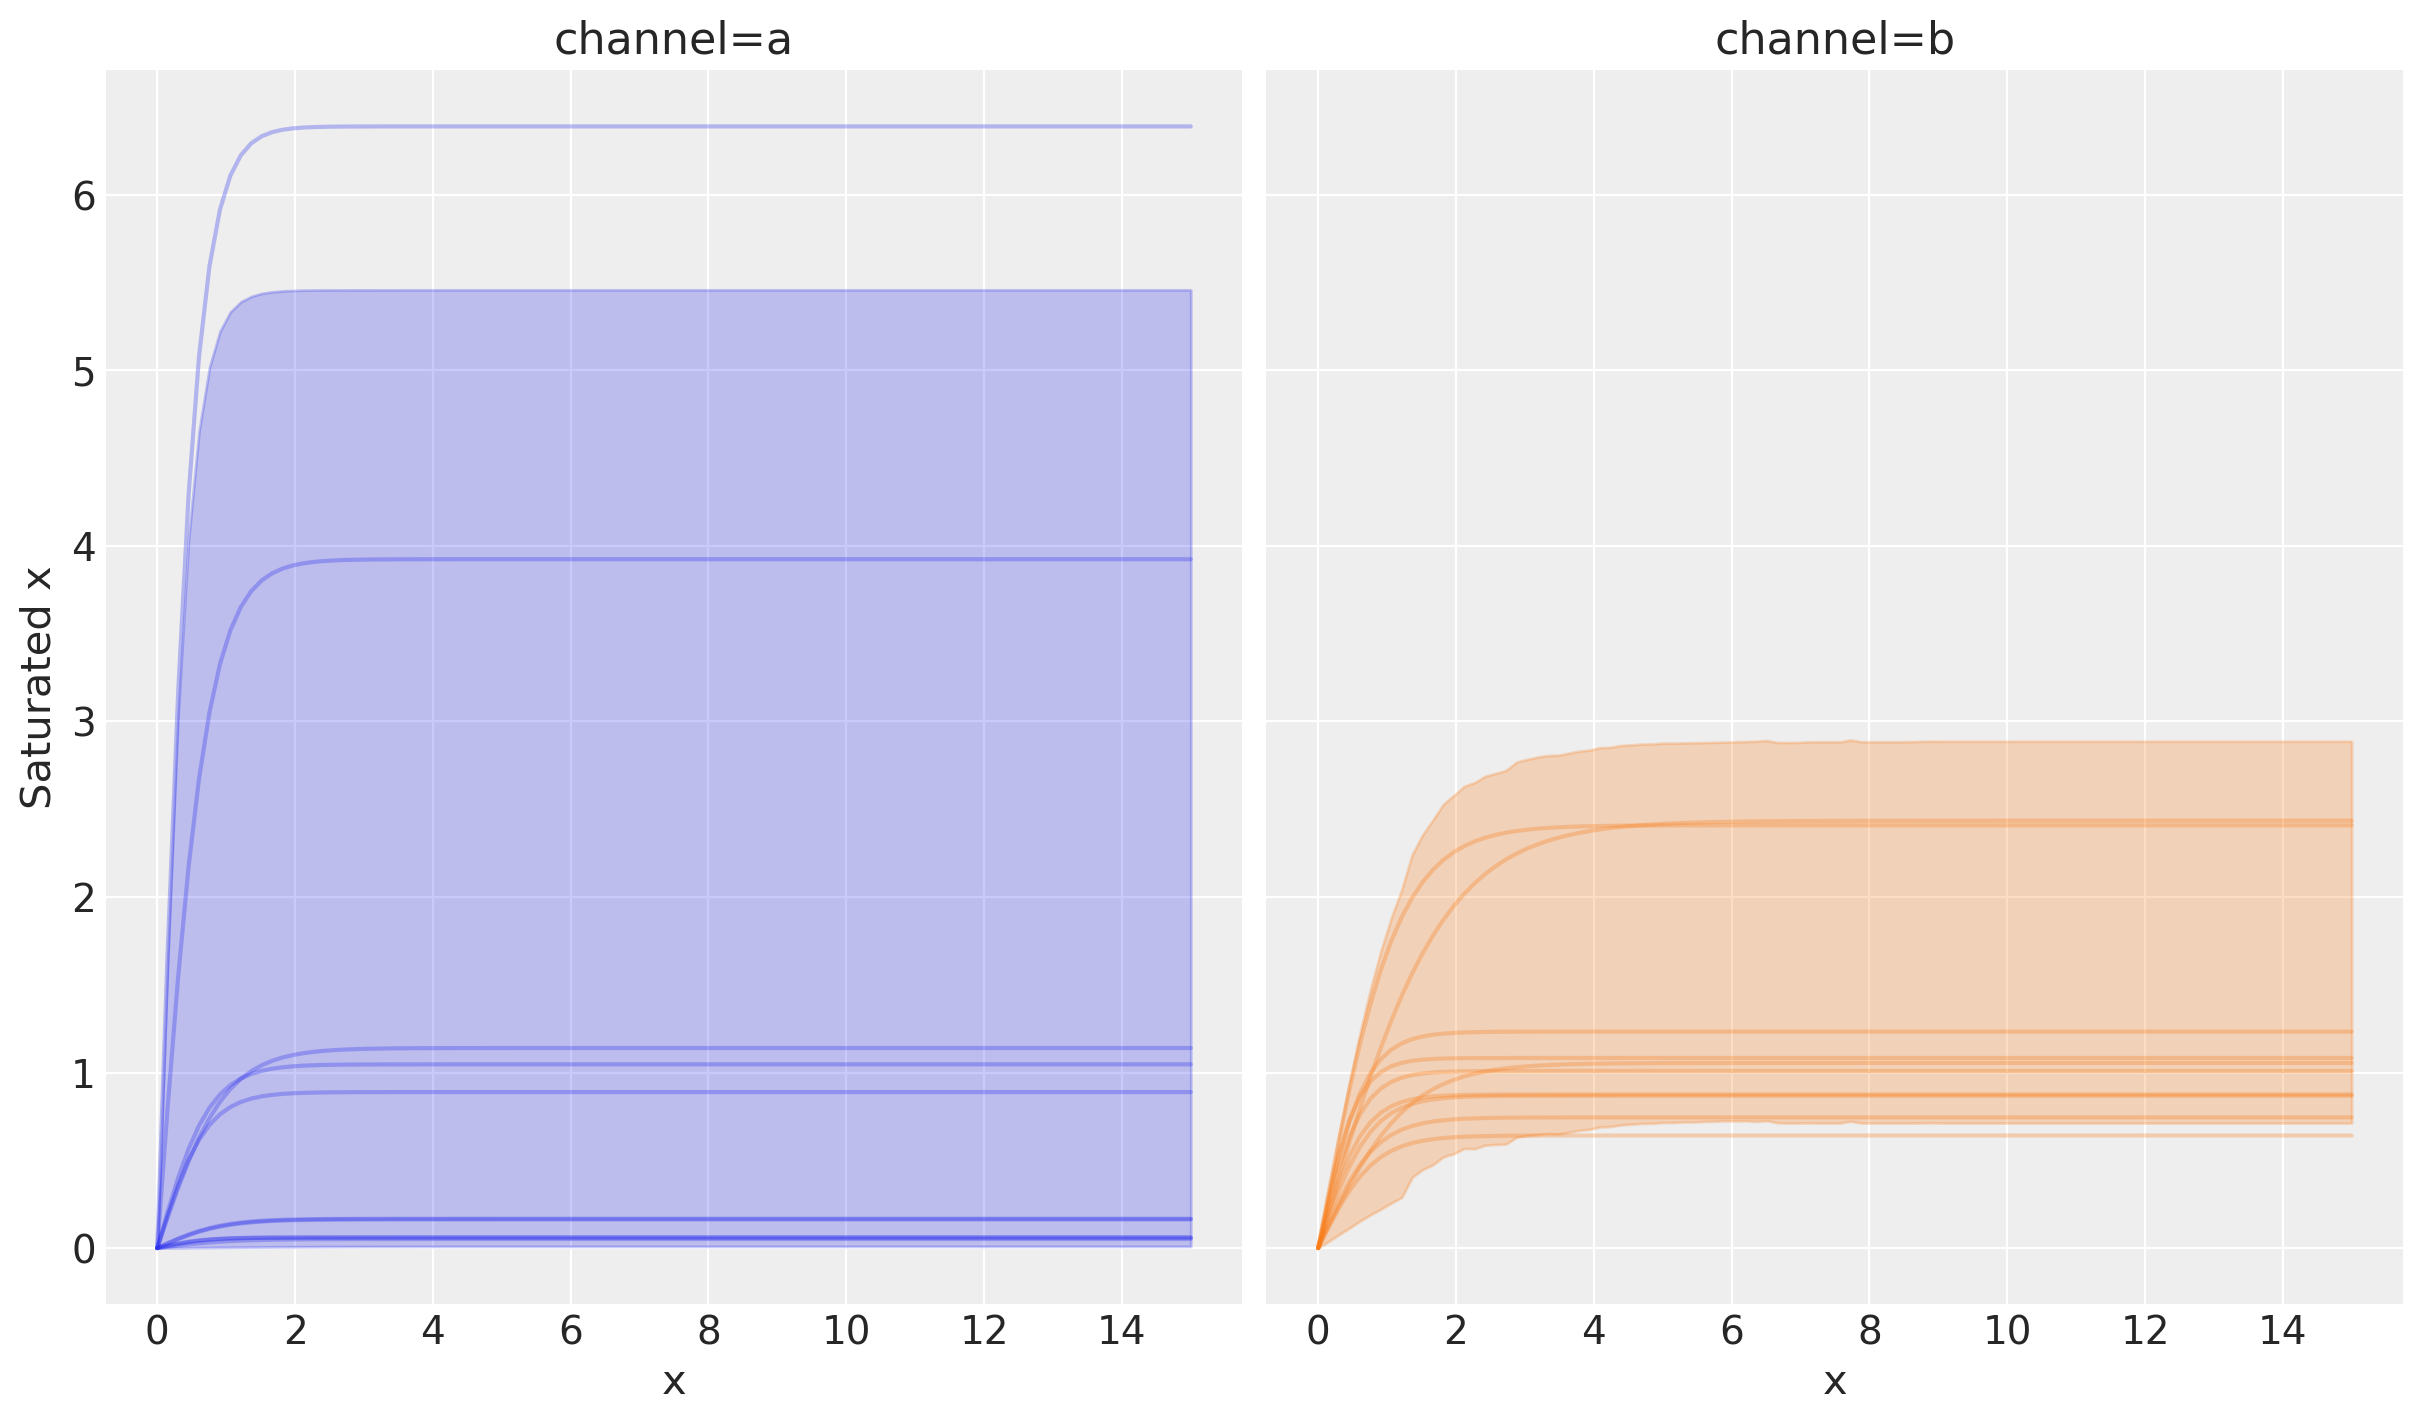

In [30]:
# mmm.saturation.plot_curve(curve=mmm.idata.posterior[["saturation_lam","saturation_beta"]]);

curve = mmm.saturation.sample_curve(
    mmm.idata.posterior[[var for var in mmm.idata.posterior.data_vars if var.startswith("saturation_")]], 
    max_value=15
)
_, axes = mmm.saturation.plot_curve(curve)
axes[0].set(
    ylabel="Saturated x",
    # title="Posterior Saturation Curve",
);

In [21]:
mmm = MMM(
    date_column="date",
    target_column="target",
    channel_columns=["a", "b"],
    # dims=("country",),
    adstock=GeometricAdstock(l_max=8),
    saturation=MichaelisMentenSaturation(),
)

# df.drop(columns="country", inplace=True)

In [22]:
mmm.fit(
    X=df.drop(columns=["country", "target"]), y=df.drop(columns=[*channels, "country"])
)

-init-
-end-


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, adstock_alpha, saturation_lam, saturation_beta, y_sigma]
/opt/anaconda3/envs/pymc-marketing-dev/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Output()

/opt/anaconda3/envs/pymc-marketing-dev/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 44 seconds.
There were 248 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details


Inference data with groups:
	> posterior
	> sample_stats
	> observed_data
	> constant_data

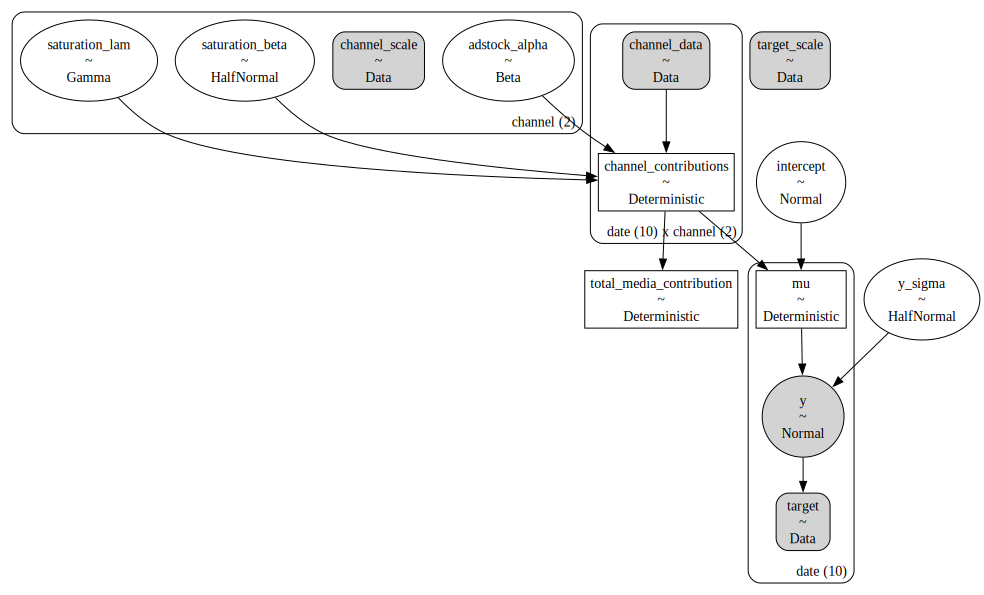

In [23]:
pm.model_to_graphviz(mmm.model)

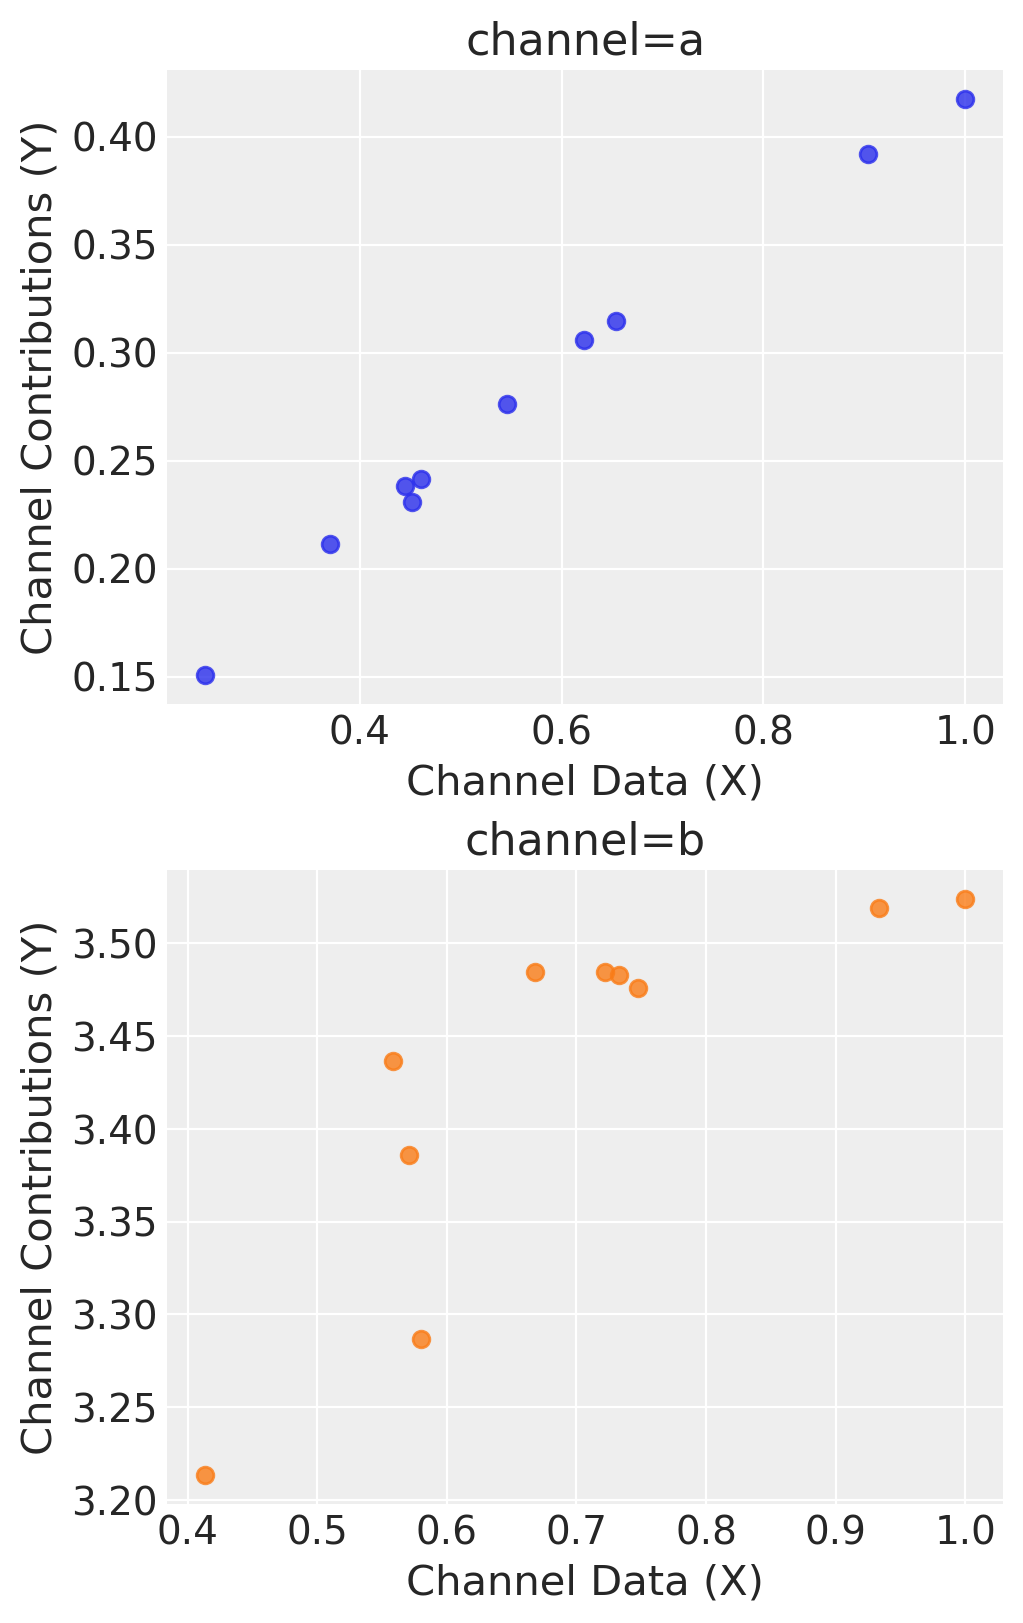

In [24]:
mmm.plot_saturation_curves_scatter();